In [384]:
# !pip install qiskit qiskit-aer pylatexenc

In [385]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

import numpy as np

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

%matplotlib inline


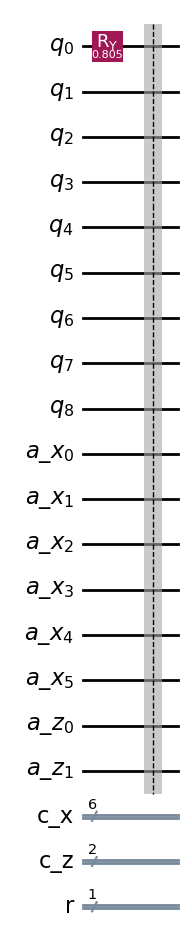

In [386]:
# ========================================
# STEP 1: STEUP
# ========================================
q = QuantumRegister(9, 'q')
a_x = QuantumRegister(6, 'a_x')   # X-syndrome (bit-flip)
a_z = QuantumRegister(2, 'a_z')   # Z-syndrome (phase)
c_x = ClassicalRegister(6, 'c_x')   # classical bits
c_z = ClassicalRegister(2, 'c_z')
c_r = ClassicalRegister(1, 'r')   # result bit

qc = QuantumCircuit(q, a_x, a_z, c_x, c_z, c_r)


# ========================================
# STEP 2: STATE INITIALIZATION (RANDOM)
# ========================================
u = np.random.uniform(0, 1)
theta = np.arccos(u)
qc.ry(theta, q[0])
qc.barrier()





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig


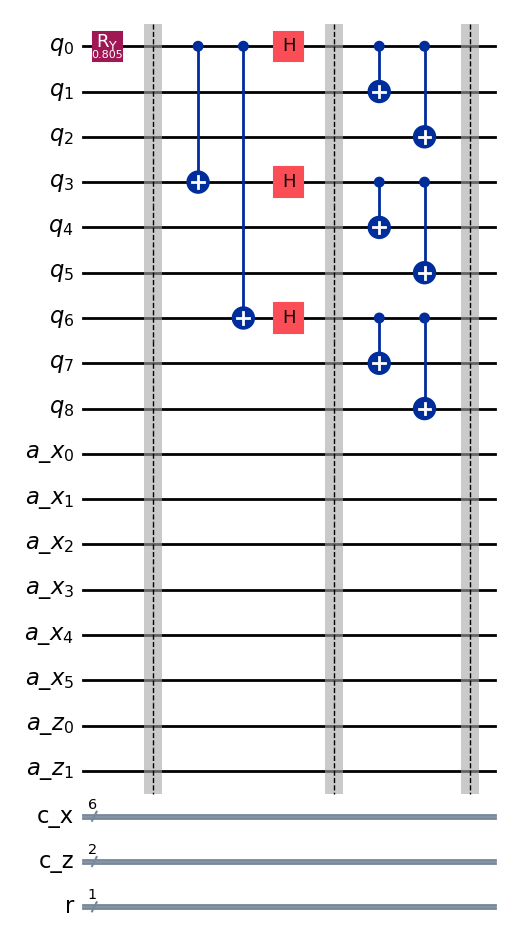

In [387]:
# ========================================
# STEP 3: ENCODING
# ========================================
# copy to block leaders
qc.cx(q[0], q[3])
qc.cx(q[0], q[6])

# Hadamard on block leaders
for i in [0, 3, 6]:
    qc.h(q[i])
qc.barrier()

# repetition inside each block
for i in [0, 3, 6]:
    qc.cx(q[i], q[i+1])
    qc.cx(q[i], q[i+2])
qc.barrier()





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig


Injected Z on q5


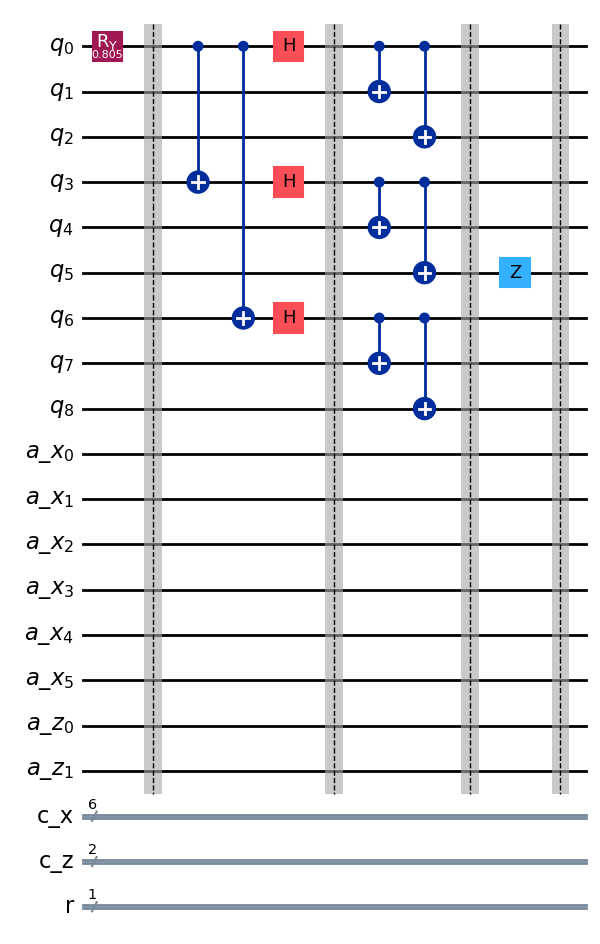

In [388]:
# ========================================
# STEP 4: Error Injection
# ========================================
gate_arr = ['x', 'y', 'z']
gate = np.random.choice(gate_arr)

idx = np.random.randint(0, 9)
print(f"Injected {gate.upper()} on q{idx}")

getattr(qc, gate)(q[idx])
qc.barrier()





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

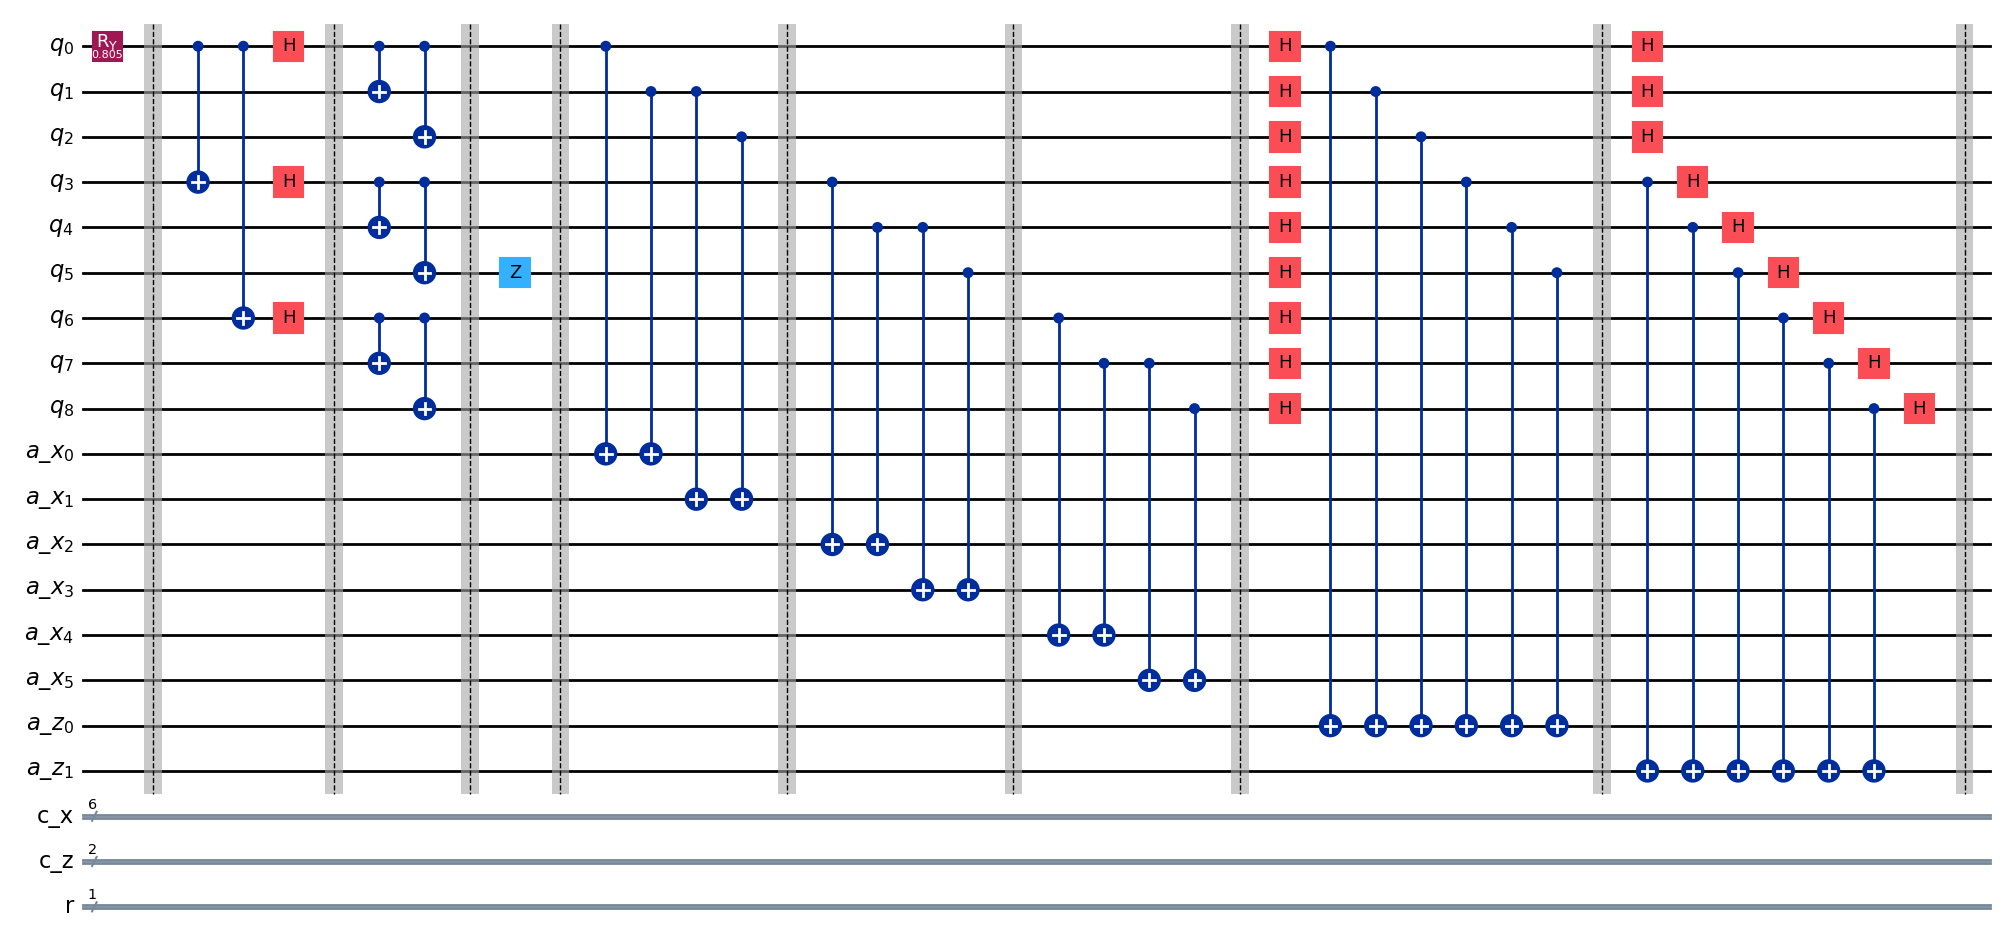

In [389]:
# ========================================
# STEP 5: SYNDROME EXTRACTION
# ========================================
# ======= X-Syndrome =======
# block 1
pairs = [(0,1),(1,2)]
for i, (p, r) in enumerate(pairs):
    qc.cx(q[p], a_x[i])
    qc.cx(q[r], a_x[i])
qc.barrier()
# block 2
pairs = [(3,4),(4,5)]
for i, (p, r) in enumerate(pairs):
    qc.cx(q[p], a_x[i+2])
    qc.cx(q[r], a_x[i+2])
qc.barrier()
# block 3
pairs = [(6,7),(7,8)]
for i, (p, r) in enumerate(pairs):
    qc.cx(q[p], a_x[i+4])
    qc.cx(q[r], a_x[i+4])
qc.barrier()

# ======= Z-Syndrome =======
# rotate DATA to X-basis
for i in range(9):
    qc.h(q[i])

# block 1 vs 2
for i in range(0, 6):
    qc.cx(q[i], a_z[0])
qc.barrier()

# block 2 vs 3
for i in range(3, 9):
    qc.cx(q[i], a_z[1])

# rotate DATA back
for i in range(9):
    qc.h(q[i])
qc.barrier()





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

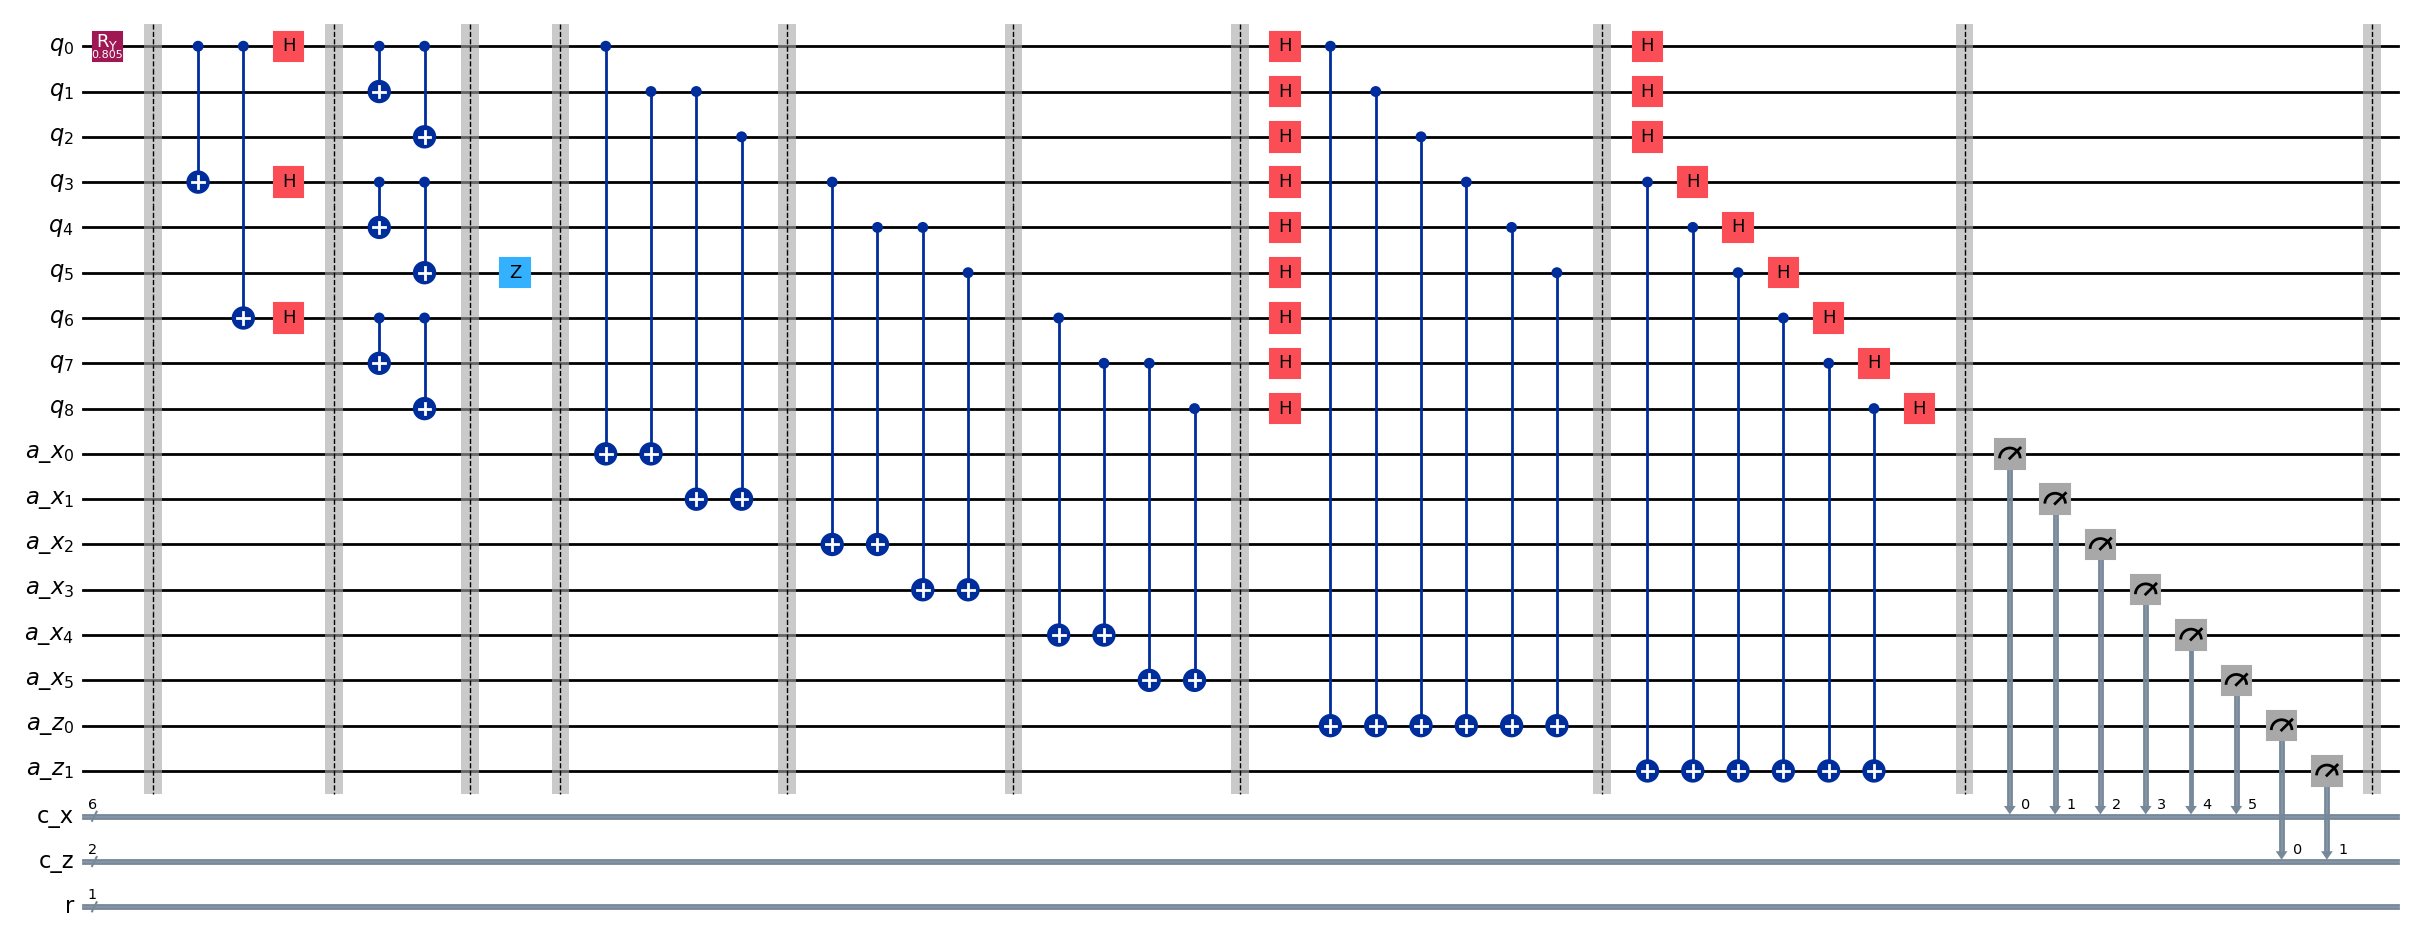

In [390]:
# ========================================
# STEP 6: SYNDROME MEASUREMENT
# ========================================
for i in range(6):
    qc.measure(a_x[i], c_x[i])
qc.measure(a_z, c_z)
qc.barrier()





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

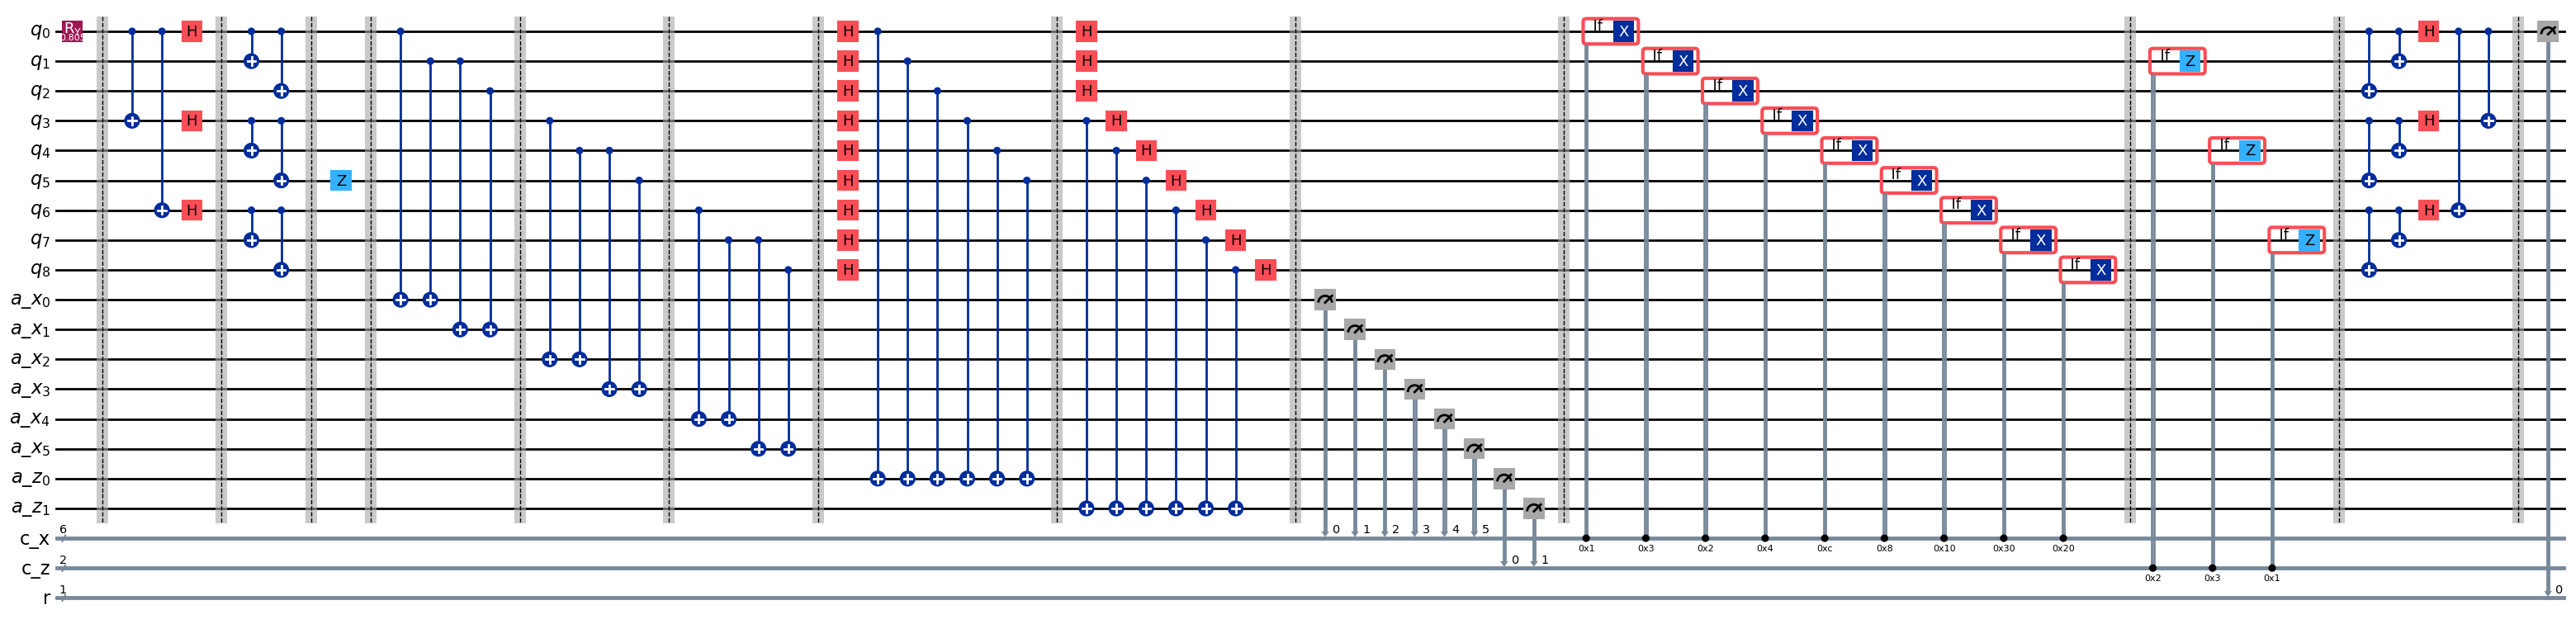

In [391]:
# ========================================
# STEP 7: DECODING
# ========================================
# ======= BIT FLIP =======
with qc.if_test((c_x, 0b000001)): qc.x(q[0])
with qc.if_test((c_x, 0b000011)): qc.x(q[1])
with qc.if_test((c_x, 0b000010)): qc.x(q[2])

with qc.if_test((c_x, 0b000100)): qc.x(q[3])
with qc.if_test((c_x, 0b001100)): qc.x(q[4])
with qc.if_test((c_x, 0b001000)): qc.x(q[5])

with qc.if_test((c_x, 0b010000)): qc.x(q[6])
with qc.if_test((c_x, 0b110000)): qc.x(q[7])
with qc.if_test((c_x, 0b100000)): qc.x(q[8])

qc.barrier()

# ======= PHASE FLIP =======
with qc.if_test((c_z, 0b10)): qc.z(q[1])
with qc.if_test((c_z, 0b11)): qc.z(q[4])
with qc.if_test((c_z, 0b01)): qc.z(q[7])

qc.barrier()

# ======= Decode back =======
# undo repetition
for i in [0, 3, 6]:
    qc.cx(q[i], q[i+2])
    qc.cx(q[i], q[i+1])

# undo Hadamards
for i in [0, 3, 6]:
    qc.h(q[i])

# undo block copies
qc.cx(q[0], q[6])
qc.cx(q[0], q[3])

qc.barrier()

# ======= Final state measurement =======
qc.measure(q[0], c_r)





# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

counts: {'1 11 000000': 149, '0 11 000000': 875}

Z syndrome: 11
X syndrome: 000000

Theoretical P(0): 0.8467
Experimental P(0): 0.8545
Difference: 0.0078


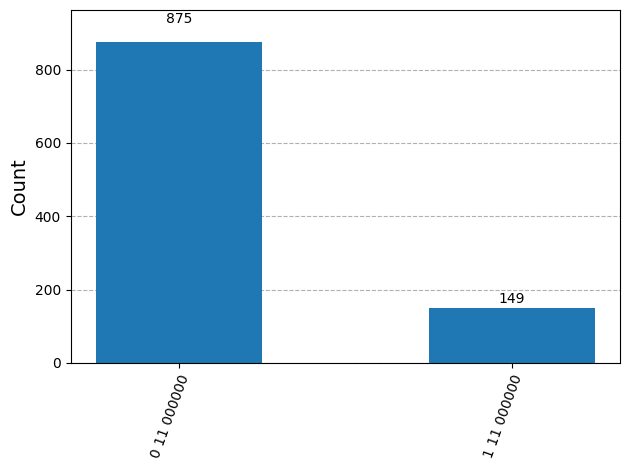

In [392]:

# =========================================
# 8. Execution & Analysis
# =========================================
# ======= Execution =======
simulator = AerSimulator()
qc_transpiled = transpile(qc, simulator)
shots=1024
job = simulator.run(qc_transpiled, shots=shots)
result = job.result()
counts = result.get_counts()
print(f"counts: {counts}")

# ======= Z/X syndrome =======
bits = list(counts.keys())[0]
parts = bits.split()

z_syn = parts[-2][::-1]
x_syn = parts[-1][::-1]

print("\nZ syndrome:", z_syn)
print(f"X syndrome: {x_syn}\n")



# ======= Calculate P(0) Theoretical vs Experimental =======
# Theoretical P(0) = cos^2 (0/2) = [ cos(0) + 1 ] / 2
p0_theory = ( u + 1)/2
# Experimental P(0)
count_0 = sum(count for key, count in counts.items() if key.split()[0] == '0')
p0_exp = count_0 / shots

print("=" * 50)
print(f"Theoretical P(0): {p0_theory:.4f}")
print(f"Experimental P(0): {p0_exp:.4f}")
print(f"Difference: {abs(p0_theory - p0_exp):.4f}")
print("=" * 50)



# ======= Plot counts =======
plot_histogram(counts)